# Classifiez automatiquement des biens de consommation - Text & Image Features extraction

Pascaline Grondein

Début : 04/07/2022

<i/>Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.</i>

<i/>Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.</i>

<i/>Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.</i>

<i/>Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.</i>

In [10]:
import os, sys, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget

import csv

import nltk
import contractions
import re
import string

from time import time
from datetime import datetime

import random

#ACP
from ACP import *
from sklearn.decomposition import PCA

#visualization
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

import warnings
warnings.filterwarnings("ignore")

In [11]:
path = 'C:/Users/pgron/Jupyter/P6/data/source/'
fn = path + 'df_image.csv'

df = pd.read_csv(fn)
df.head(1)

,uniq_id,image,true_label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing


In [12]:
feat_txt = pd.read_csv('feat_txt.csv')
#feat_txt.head(1)

feat_image = pd.read_csv('feat_image.csv')
#feat_txt.head(1)

feat_all = pd.concat([feat_txt, feat_image], axis = 1)
#feat_all.head(1)

In [13]:
# Reduction    
def reduc(features, n_comp) :
    
    #ACP
    feat_pca = features
    pca = PCA(n_components = n_comp)
    pca_res = pca.fit_transform(feat_pca)
    display_scree_plot(pca)
    
    #tSNE
    feat_tsne = features
    tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, 
                         init = 'random', learning_rate = 200, random_state = 42)
    X_tsne = tsne.fit_transform(feat_tsne)
    
    return X_tsne, pca_res

# Clustering par kmeans
def kmeans_(df, X) :
    
    #True labels
    true_labels = list(set(df['true_label']))
    nb_labels = len(true_labels)
    #print('Number of true labels :', nb_labels)
    
    # Kmeans
    cls = cluster.KMeans(n_clusters = nb_labels, n_init = 100, random_state = 42)
    cls.fit(X)
    cl_labels = cls.labels_
    
    return cl_labels


# Visualisation w/ Tsne (true labels or kmeans clusters)
def TSNE_visu_ARI(df, X_tsne, cl_labels) :
    
    #True labels
    true_labels = list(set(df['true_label']))
    true_num_labels = [(true_labels.index(df.iloc[i]['true_label'])) 
                       for i in range(len(df))]
    nb_labels = len(true_labels)
    
    fig = plt.figure(figsize=(15,6))
        
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c = true_num_labels, cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = true_labels, 
              loc = "best", title = "Catégories")
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title('Produits par catégories réelles', Fontsize = 20)
    

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c = cl_labels, cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = set(cl_labels), 
              loc = "best", title = "Clusters")
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title('Produits par clusters', Fontsize = 20)
    
    plt.show()
    
    ARI = np.round(metrics.adjusted_rand_score(true_num_labels, cl_labels),4)
    print("ARI : ", ARI)
    print('         ')
    
    return ARI

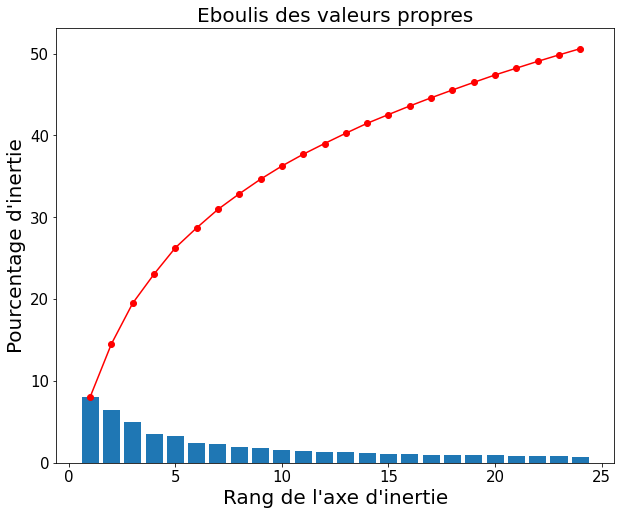

       
                                   --- PCA reduction ----


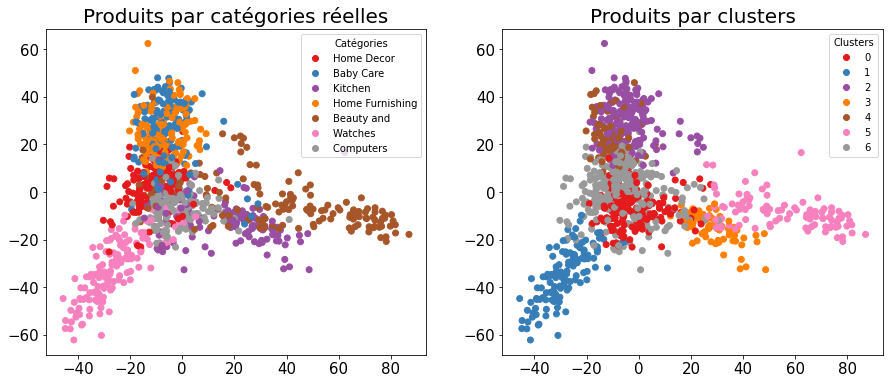

ARI :  0.4639
         
       
       
                                   --- tSNE reduction ----


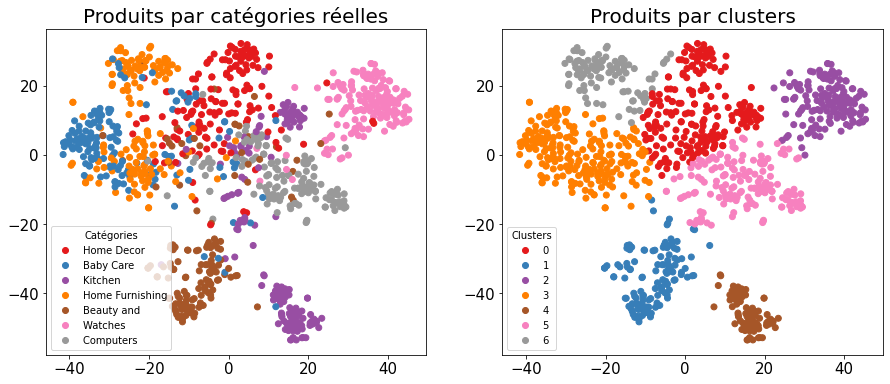

ARI :  0.4696
         
       


In [14]:
ari_concat = pd.DataFrame()

Xtsne, pca_res = reduc(feat_all, n_comp = 0.5)
    
print('       ')
print('                                   --- PCA reduction ----')
cl_labels_pca =  kmeans_(df, pca_res)
ari_pca = TSNE_visu_ARI(df, pca_res, cl_labels_pca)
print('       ')
    
print('       ')
print('                                   --- tSNE reduction ----')
cl_labels_tsne =  kmeans_(df, Xtsne)
ari_tsne = TSNE_visu_ARI(df, Xtsne, cl_labels_tsne)
print('       ')
    
ari_concat = pd.DataFrame(data = {'PCA' : ari_pca, 't-SNE' : ari_tsne}, index = [''])

In [15]:
ari_concat

,PCA,t-SNE
,0.4639,0.4696


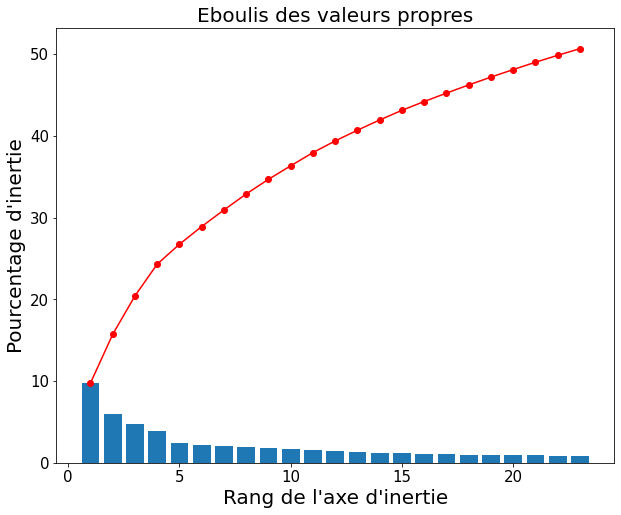

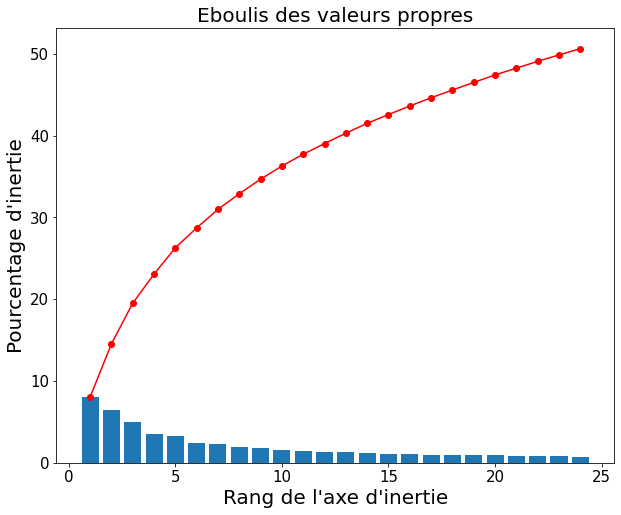

       
                                   --- PCA reduction ----


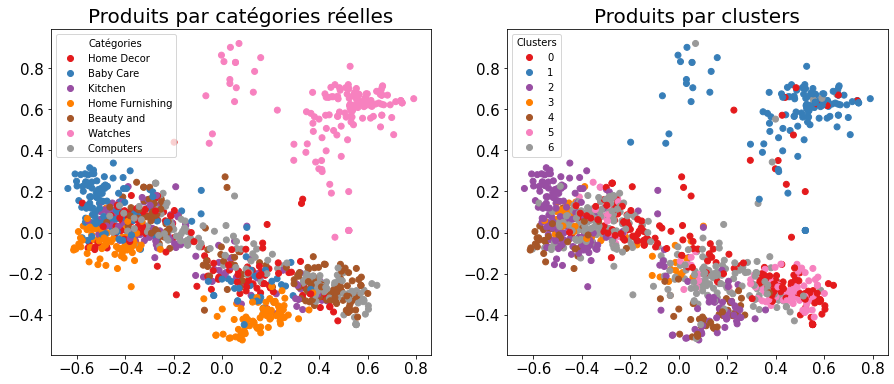

ARI :  0.4639
         
       
       
                                   --- tSNE reduction ----


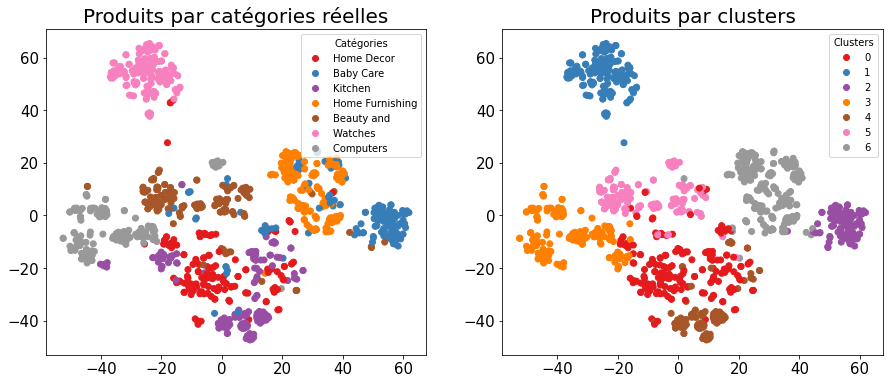

ARI :  0.6483
         
       


In [16]:
ari_nonconcat = pd.DataFrame()

Xtsne_txt, pca_res_txt = reduc(feat_txt, n_comp = 0.5)
Xtsne_image, pca_res_image = reduc(feat_image, n_comp = 0.5)

Xtsne = np.concatenate((Xtsne_txt, Xtsne_image), axis = 1)
pca_res = np.concatenate((pca_res_txt, pca_res_image), axis = 1)

print('       ')
print('                                   --- PCA reduction ----')
cl_labels_pca =  kmeans_(df, pca_res)
ari_pca = TSNE_visu_ARI(df, pca_res, cl_labels_pca)
print('       ')
    
print('       ')
print('                                   --- tSNE reduction ----')
cl_labels_tsne =  kmeans_(df, Xtsne)
ari_tsne = TSNE_visu_ARI(df, Xtsne, cl_labels_tsne)
print('       ')
    
ari_nonconcat = pd.DataFrame(data = {'PCA' : ari_pca, 't-SNE' : ari_tsne}, index = [''])

In [17]:
ari_nonconcat

,PCA,t-SNE
,0.4639,0.6483
